In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import split_dataset
from tensorflow.keras.callbacks import ModelCheckpoint

2024-04-10 16:05:11.133047: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 16:05:11.154988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 16:05:11.155009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 16:05:11.155488: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 16:05:11.158984: I tensorflow/core/platform/cpu_feature_guar

In [14]:
image_path = "processed_data/partially_processed/uncompressed"
batch_size = 32
img_height = 128
img_width = 128

## Import Images

87926 images found
image 0: processed_data/partially_processed/uncompressed/212_igb.jpeg


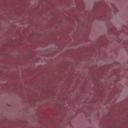

In [3]:
sample_image = 0
data_dir = pathlib.Path(image_path)
satalite_images = list(data_dir.glob('*.jpeg'))
image_count = len(satalite_images)
print(f"{image_count} images found")
print(f"image {sample_image}: {satalite_images[0]}")
Image.open(str(satalite_images[0]))


In [5]:
table_df = pd.read_pickle("processed_data/partially_processed/top500_df_elevation_onehot_grouped.pkl")
Y = table_df.drop(columns=['surveyId',
    'Unnamed: 0',
    'lon',
    'lat',
    'year',
    'areaInM2',
    'region',
    'speciesId',
    'ALPINE',
    'ATLANTIC',
    'BLACK SEA',
    'BOREAL',
    'CONTINENTAL',
    'MEDITERRANEAN',
    'PANNONIAN',
    'STEPPIC'
])

In [6]:
class_names = Y.columns

In [16]:
data_dir = pathlib.Path(image_path)

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=113,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: No images found in directory processed_data/partially_processed/uncompressed. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [8]:
Y_train, Y_val = split_dataset(np.asarray(Y), left_size=0.8, shuffle=True, seed=113)

2024-04-10 15:20:36.937748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 15:20:37.051370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 15:20:37.051495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
tf.data.Dataset.save(Y_train, "processed_data/partially_processed/top500_images_Y_train")
tf.data.Dataset.save(Y_val, "processed_data/partially_processed/top500_images_Y_val")

In [11]:
X_train, X_val = split_dataset(X, left_size=0.8, shuffle=True, seed=113)

In [12]:
tf.data.Dataset.save(X_train, "processed_data/partially_processed/top500_images_X_train")
tf.data.Dataset.save(X_val, "processed_data/partially_processed/top500_images_X_val")

In [25]:
X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
Y_train_np = np.array(Y_train)
Y_val_np = np.array(Y_val)

In [13]:
normalisation_layer = layers.Rescaling(1./255)

In [14]:
num_classes = len(class_names)

In [16]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [19]:
epochs = 10
cp = ModelCheckpoint('model/top500/', save_best_only=True)

In [26]:
history = model.fit(x=X_train_np, y=Y_train_np, validation_data=(X_val_np, Y_val_np), epochs=epochs, callbacks=[cp])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type _PrefetchDataset).

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
